<a href="https://colab.research.google.com/github/S-Ahsan-Haider/Case-Studies/blob/main/Case_Study_RecSys_Movies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement
* Develop movie recommender systems.
* Implement item-based and user-based collaborative filtering.
* Use Pearson Correlation, Cosine Similarity, KNN, and Matrix Factorization.
* Evaluate models with RMSE/MAPE.
* Explore embedding usage.
* (Optional) Implement user-input recommendations.


## Importing Libraries & Uploading Files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import csv
import os
pd.set_option('display.max_columns', 50)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving zee-movies.csv to zee-movies (1).csv
Saving zee-ratings.csv to zee-ratings (1).csv
Saving zee-users.csv to zee-users (1).csv


In [ ]:
for filename in uploaded:
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

In [ ]:
movies = pd.read_csv(io.BytesIO(uploaded['zee-movies (1).csv']))
ratings = pd.read_csv(io.BytesIO(uploaded['zee-ratings (1).csv']))
users = pd.read_csv(io.BytesIO(uploaded['zee-users (1).csv']))

# Dataframe Cleaning & Creation of New DataFrames

In [ ]:
m = movies.copy()
r = ratings.copy()
u = users.copy()

r.columns= ['user_id','movie_id','rating','timestamp']
u.columns= ['user_id','gender','age','occupation','zip']
m.columns= ['movie_id','title','genres','extra','extra2']   # Thsi has two extra faulty columns that need correction

In [ ]:
# Correcting the rows where the columns are shifted by one

print(m.shape)

selct = m['extra'].notna()            # Filtering/Selecting Rows with Non-NaN 'extra' Values

# Modifying 'title' and 'genres' for Selected Rows

m.loc[selct, 'title'] = m.loc[selct, 'title'] + ' ' + m.loc[selct, 'genres']
m.loc[selct, 'genres'] = m.loc[selct, 'extra']

m = m[m['extra2'].isna()]                   #  Now only taking Rows with NaN 'extra2' Values

m = m.drop('extra', axis=1)
m = m.drop('extra2', axis=1)

print()
print(m.shape)
m.head(2)

(3883, 5)

(3851, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [ ]:
# Creating a new DataFrame, df

df = pd.merge(r, m, on='movie_id', how='left')
df = pd.merge(df, u, on='user_id', how='left')

# Creating a New Feature: year

import re

df['year'] = df['title'].str.extract(r'\((\d{4})\)')
df = df.drop('timestamp', axis=1)

In [ ]:
# Splitting Genre Tags

genre_cols = df['genres'].str.split('|', expand=True)

genre_cols.columns = [f'c{i+1}' for i in range(genre_cols.shape[1])]  # Rename the new columns

df = pd.concat([df, genre_cols], axis=1) # Concatenate the new columns with the original DataFrame

for i in range(1, 6):
    if f'c{i}' not in df.columns:
        df[f'c{i}'] = np.nan             # Filling with NaN if needed to fill empty ones, if not 5 tags

cols = list(df.columns)
cols_to_move = [f'c{i}' for i in range(1, 7)]    # Reorder columns to ensure c1-c6 are at the end.
for col in cols_to_move:
    cols.remove(col)
cols.extend(cols_to_move)

df = df[cols]

df.head(2)

,user_id,movie_id,rating,title,genres,gender,age,occupation,zip,year,c1,c2,c3,c4,c5,c6
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,1975,Drama,None,None,None,None,None
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,1996,Animation,Children's,Musical,None,None,None


In [ ]:
# Replacing Genre strings with Numerical Values for ease

genre_dict = {
    "action": 1,
    "adventure": 2,
    "animation": 3,
    "children's": 4,
    "comedy": 5,
    "crime": 6,
    "documentary": 7,
    "drama": 8,
    "fantasy": 9,
    "film-noir": 10,
    "horror": 11,
    "musical": 12,
    "mystery": 13,
    "romance": 14,
    "sci-fi": 15,
    "thriller": 16,
    "war": 17,
    "western": 18
}

def replace_genre(genre_string):
    """Replaces genre strings with numerical values."""
    if isinstance(genre_string, str):               # Checking if it's a string
        genre_string = genre_string.lower()         # lower case the string
        return genre_dict.get(genre_string, None)   # Return the numerical value or None if not found
    else:
        return None

In [ ]:
# Replacing genre strings with numerical values

df['c1'] = df['c1'].apply(replace_genre)
df['c2'] = df['c2'].apply(replace_genre)
df['c3'] = df['c3'].apply(replace_genre)
df['c4'] = df['c4'].apply(replace_genre)
df['c5'] = df['c5'].apply(replace_genre)
df['c6'] = df['c6'].apply(replace_genre)

In [ ]:
# Filling missing tags in the genre columns as zeroes

df['c1'] = df['c1'].fillna(0)
df['c2'] = df['c2'].fillna(0)
df['c3'] = df['c3'].fillna(0)
df['c4'] = df['c4'].fillna(0)
df['c5'] = df['c5'].fillna(0)
df['c6'] = df['c6'].fillna(0)

In [ ]:
# Correcting the types of columns

df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

In [ ]:
df.head(2)

,user_id,movie_id,rating,title,genres,gender,age,occupation,zip,year,c1,c2,c3,c4,c5,c6
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,1975,8.0,0.0,0.0,0.0,0.0,0.0
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,1996,3.0,4.0,12.0,0.0,0.0,0.0


In [ ]:
# Creating an aggregated movies dataframe for ease of use in RecSystems
# (DataFrame with top 3 defining genre Tags only)

m_agg = df.groupby('title').agg(
    user_id_count=('user_id', 'count'),
    average_rating=('rating', 'mean'),
    mode_movie_id=('movie_id', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    mean_age=('age', 'mean'),
    mode_occupation=('occupation', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    mode_c1=('c1', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    mode_c2=('c2', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    mode_c3=('c3', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
).reset_index()

In [ ]:
m_agg.columns = ['title', 'ratings', 'mean_rating', 'movie_id', 'mean_age',
       'mode_occupation', 'c1', 'c2', 'c3']

m_agg.head(3)

,title,ratings,mean_rating,movie_id,mean_age,mode_occupation,c1,c2,c3
0,'Night Mother (1986),70,3.371429,3112,33.271429,0,8.0,0.0,0.0
1,'Til There Was You (1997),52,2.692308,779,28.826923,7,8.0,14.0,0.0
2,'burbs The (1989),303,2.910891,2072,27.897690,4,5.0,0.0,0.0


# Data Structure & EDA

In [ ]:
# Size-shape of the DataFrames

print("Shape of movies dataframe:", movies.shape,'\n')
print("Shape of ratings dataframe:", ratings.shape,'\n')
print("Shape of users dataframe:", users.shape,'\n')

Shape of movies dataframe: (3883, 5) 

Shape of ratings dataframe: (1000209, 4) 

Shape of users dataframe: (6040, 5) 



In [ ]:
# Datatype and numerical info about the Dataframes

print("movies dataframe","-"*50, '\n')
print(movies.info(), '\n')
print(movies.describe().T)
print('\n\n')

print("ratings dataframe","-"*50, '\n')
print(ratings.info(), '\n')
print(ratings.describe().T)
print('\n\n')

print("users dataframe","-"*50, '\n')
print(users.info(), '\n')
print(users.describe().T)
print('\n\n')

movies dataframe -------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Movie ID    3883 non-null   int64 
 1   Title       3883 non-null   object
 2   Genres      3883 non-null   object
 3   Extra       993 non-null    object
 4   Unnamed: 4  32 non-null     object
dtypes: int64(1), object(4)
memory usage: 151.8+ KB
None 

           count         mean          std  min    25%     50%     75%     max
Movie ID  3883.0  1986.049446  1146.778349  1.0  982.5  2010.0  2980.5  3952.0



ratings dataframe -------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    10002

Only these two columns in movies dataframe have null values:
- Extra (object)
- Unnamed: 4 (object)

Otherwise there are zero null values in any column of any dataset

In [ ]:
# No of movies, users and rating categories

print("From the ratings data, we know that ther are \n")
print('Unique users:',r['user_id'].nunique(),'\n')
print('Rating categories:',r['rating'].nunique(),'\n')
print('Unique movies:',r['movie_id'].nunique())

From the ratings data, we know that ther are 

Unique users: 6040 

Rating categories: 5 

Unique movies: 3706


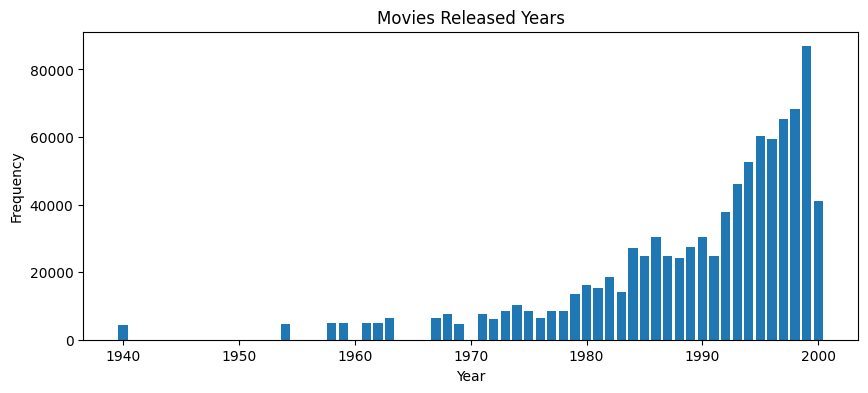

In [ ]:
# Decade with the highest no. of Movies made

t = df['year'].value_counts().head(40)

plt.figure(figsize=(10,4))
plt.bar(t.index, t.values)

plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Movies Released Years")

plt.show()

In [ ]:
# What and who is watching

occupation_dict = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}


# Occupation-wise

i = df['occupation'].value_counts().index[0]
o = occupation_dict[i]
print(f"Most Watched by: {o}s")
print()


# Gender-wise

i = df['gender'].value_counts().index[0]
if i=='M':
  print("Most Watched by: Males")
else:
  print("Most Watched by: Females")
print()


# Title-wise

t = df['title'].value_counts()
print(f"The most frequent title is: '{t.index[0]}' with a count of: {t.iloc[0]}")
print()

bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-24', '25-34', '35-49', '50-64', '65+']


# Age-wise

p = pd.DataFrame()
p['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
p['age_bins'].value_counts().head(3)

Most Watched by: college/grad students

Most Watched by: Males

The most frequent title is: 'American Beauty (1999)' with a count of: 3428



,count
age_bins,
25-34,395556
35-49,282636
18-24,183536


In [ ]:
m_agg.head(2)

,title,ratings,mean_rating,movie_id,mean_age,mode_occupation,c1,c2,c3
0,'Night Mother (1986),70,3.371429,3112,33.271429,0,8.0,0.0,0.0
1,'Til There Was You (1997),52,2.692308,779,28.826923,7,8.0,14.0,0.0


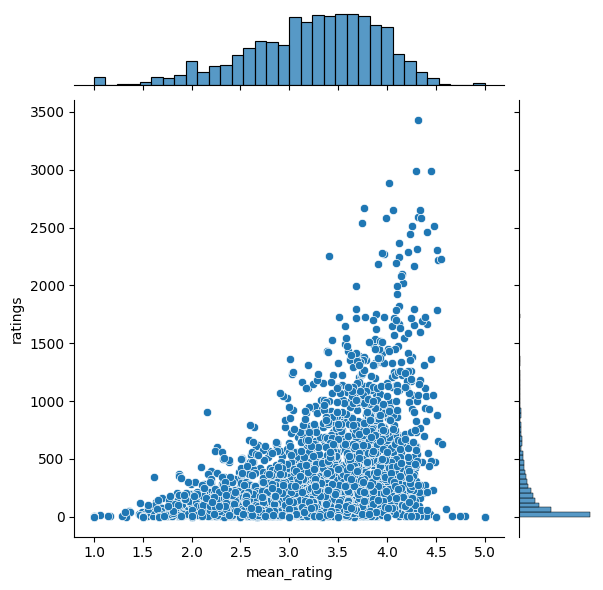

In [ ]:
# Relation between no. of ratings and mean rating

sns.jointplot(data=m_agg, y='ratings', x='mean_rating')

- Popular movies tend to get higher ratings

# Visualisation Using Embeddings & KNN Recommender Model

### Data Shortening

In [ ]:
# Selecting Users who have rated more thna 300 movies (to shorten the data)

x = df.groupby('user_id')['rating'].count()
exp_users = x[x > 300].index

df1 = df[df['user_id'].isin(exp_users)]

print(df1['user_id'].nunique())
print(df1.shape)
df1.head(2)

955
(501942, 16)


,user_id,movie_id,rating,title,genres,gender,age,occupation,zip,year,c1,c2,c3,c4,c5,c6
799,10,2622,5,Midsummer Night's Dream A (1999),Comedy|Fantasy,F,35,1,95370,1999,5.0,9.0,0.0,0.0,0.0,0.0
800,10,648,4,Mission: Impossible (1996),Action|Adventure|Mystery,F,35,1,95370,1996,1.0,2.0,13.0,0.0,0.0,0.0


In [ ]:
# Selecting Movies with more than 50 ratings

y = df1.groupby('title')['rating'].count()
famous_movies = y[y > 50].index

df2 = df1[df1['title'].isin(famous_movies)]

print(df2['user_id'].nunique())                  # For User User Similarity matrix, unique users required
print(df2.shape)
df2.head(2)

955
(472392, 16)


,user_id,movie_id,rating,title,genres,gender,age,occupation,zip,year,c1,c2,c3,c4,c5,c6
799,10,2622,5,Midsummer Night's Dream A (1999),Comedy|Fantasy,F,35,1,95370,1999,5.0,9.0,0.0,0.0,0.0,0.0
800,10,648,4,Mission: Impossible (1996),Action|Adventure|Mystery,F,35,1,95370,1996,1.0,2.0,13.0,0.0,0.0,0.0


In [ ]:
# Making Pivot Table (table) of Users (rows) - Movies (columns)

p_table = df2.pivot_table(index='user_id', columns = 'title', values='rating')

p_table.fillna(0, inplace=True)

print("Shape is:", p_table.shape)

# Normalising the Table as some users tend to give higher ratings while some lower

p_table = p_table.subtract(p_table.mean(axis=1), axis='rows')

p_table.head(2)

Shape is: (955, 2163)


title,'burbs The (1989),...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),13th Warrior The (1999),2 Days in the Valley (1996),20 000 Leagues Under the Sea (1954),200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),39 Steps The (1935),400 Blows The (Les Quatre cents coups) (1959),52 Pick-Up (1986),54 (1998),7th Voyage of Sinbad The (1958),8 1/2 (1963),8 Heads in a Duffel Bag (1997),8MM (1999),Abbott and Costello Meet Frankenstein (1948),About Last Night... (1986),Absent Minded Professor The (1961),Absolute Power (1997),...,Women The (1939),Women on the Verge of a Nervous Breakdown (1988),Wonder Boys (2000),Working Girl (1988),World Is Not Enough The (1999),Wrong Man The (1956),Wrong Trousers The (1993),Wrongfully Accused (1998),Wyatt Earp (1994),X-Files: Fight the Future The (1998),X-Men (2000),Year of Living Dangerously (1982),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Poisoner's Handbook The (1995),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,3.259362,-0.740638,-0.740638,-0.740638,-0.740638,2.259362,3.259362,-0.740638,3.259362,-0.740638,2.259362,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,1.259362,-0.740638,-0.740638,-0.740638,3.259362,-0.740638,4.259362,-0.740638,...,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,4.259362,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,4.259362,-0.740638,4.259362,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638,-0.740638
18,-0.502080,-0.502080,-0.502080,3.497920,0.497920,-0.502080,3.497920,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,...,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,4.497920,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,-0.502080,3.497920,2.497920,-0.502080,3.497920,-0.502080,-0.502080,-0.502080


In [ ]:
# User Similarity using Pearson Correlation

user_sim = p_table.T.corr()
user_sim.head(3)

user_id,10,18,23,26,33,36,48,53,58,62,92,117,123,136,146,148,149,151,157,163,166,169,173,175,181,...,5848,5852,5854,5878,5880,5886,5888,5890,5916,5948,5950,5954,5955,5961,5964,5972,5978,5996,6000,6002,6007,6010,6016,6036,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.259600,0.203491,0.161488,0.187646,0.214367,0.380049,0.184500,0.295964,0.187229,0.320430,0.260278,0.141655,0.214796,0.279900,0.293886,0.137968,0.212321,0.236783,0.068656,0.231903,0.311978,0.085992,0.224073,0.200844,...,0.171991,0.225510,0.063883,0.121468,0.241180,0.312163,0.277586,0.197190,0.125396,0.152589,0.188861,0.239014,0.321503,0.028589,0.254201,0.273110,0.242193,0.349115,0.264702,0.162714,0.128164,0.258826,0.259672,0.154026,0.141804
18,0.259600,1.000000,0.142588,0.100879,0.129150,0.191658,0.292327,0.234248,0.290866,0.079813,0.301186,0.284169,0.111876,0.146067,0.169244,0.201229,0.165667,0.159037,0.142527,0.140390,0.186528,0.226197,0.078150,0.214481,0.223870,...,0.124662,0.146753,0.054251,0.152808,0.198178,0.358965,0.157126,0.066932,0.111800,0.033069,0.119394,0.228277,0.214048,0.085465,0.249270,0.160348,0.297352,0.306635,0.133369,0.049280,0.102860,0.192026,0.173156,0.162669,0.068717
23,0.203491,0.142588,1.000000,0.052759,0.229497,0.287737,0.193357,0.271018,0.347522,0.115928,0.063301,0.261892,0.188875,0.142868,0.140592,0.145765,0.295232,0.289550,0.280237,0.205082,0.246072,0.275125,0.208926,0.140171,0.234114,...,0.126117,0.131236,0.183850,0.081341,0.333209,0.293655,0.116535,0.204789,0.222989,0.040140,0.198432,0.188395,0.239844,0.187235,0.229251,0.136013,0.130083,0.176215,0.135428,0.172035,0.189393,0.174039,0.176524,0.254049,0.196769


### MDS

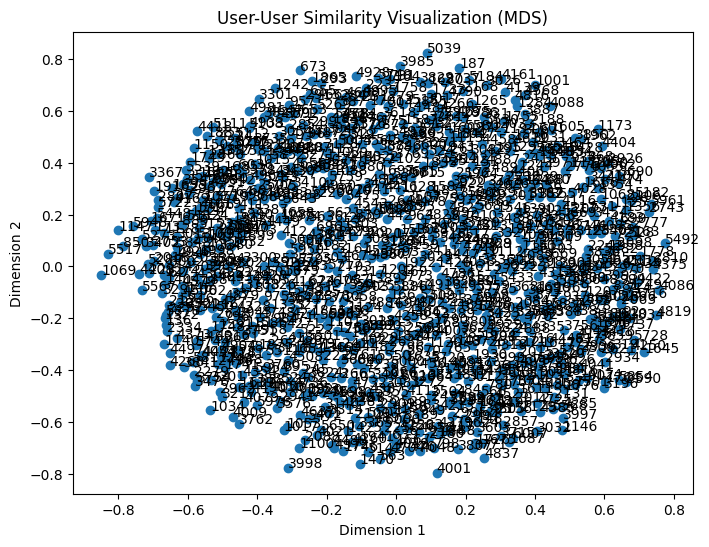

In [ ]:
from sklearn.manifold import MDS

distance_matrix = 1 - user_sim  # 1 - similarity

# Applying MDS

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
embeddings_2d = mds.fit_transform(distance_matrix)

# Plotting the 2D embeddings

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.title("User-User Similarity Visualization (MDS)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Adding annotations (user IDs)

for i, user_id in enumerate(user_sim.index):
    plt.annotate(user_id, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.show()

### PCA

Text(0, 0.5, 'Principal Component 2 (PC2)')

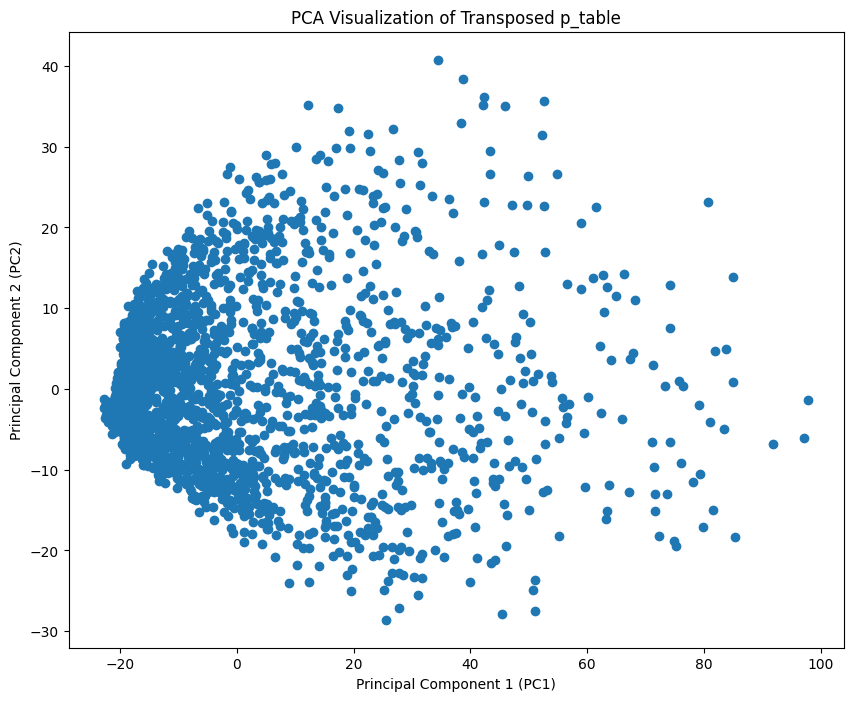

In [ ]:
from sklearn.decomposition import PCA

# Transpose as columns> rows currently
p_table_transposed = p_table.T

pca = PCA(n_components=2)                           # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(p_table_transposed)

# DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=p_table_transposed.index)


plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA Visualization of Transposed p_table')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

### KNN Recommender

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Apply KNN
knn = NearestNeighbors(n_neighbors=4, metric='cosine')
knn.fit(p_table_transposed)

# Find the nearest neighbors for a movie (example --> the very first movie)
movie_title = p_table_transposed.index[0]                                 # Get the first movie title
movie_vector = p_table_transposed.loc[movie_title].values.reshape(1, -1)  # Get movie vector

distances, indices = knn.kneighbors(movie_vector)

# Print the nearest neighbors
print(f"Nearest neighbors for '{movie_title}':")
for i in range(1, len(indices[0])):                                       # Exclude the movie itself (index 0)
    neighbor_title = p_table_transposed.index[indices[0][i]]
    print(f"- {neighbor_title} (distance: {distances[0][i]:.4f})")

Nearest neighbors for ''burbs  The (1989)':
- Harry and the Hendersons (1987) (distance: 0.6297)
- Funny Farm (1988) (distance: 0.6392)
- Money Pit  The (1986) (distance: 0.6663)


# Recommender Models Plain

### **Dataframe Creation**

Picking experienced Users and most watched Movies Only
- Movies with more than 50 ratings
- Users with more than 100 rated movies

In [ ]:
# Selecting Users who have rated more thna 100 movies

x = df.groupby('user_id')['rating'].count()
exp_users = x[x > 100].index

df1 = df[df['user_id'].isin(exp_users)]

print(df1.shape)
df1.head(2)

(843702, 16)


,user_id,movie_id,rating,title,genres,gender,age,occupation,zip,year,c1,c2,c3,c4,c5,c6
53,2,1357,5,Shine (1996),Drama|Romance,M,56,16,70072,1996,8.0,14.0,0.0,0.0,0.0,0.0
54,2,3068,4,Verdict The (1982),Drama,M,56,16,70072,1982,8.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Selecting Movies with more than 50 ratings

y = df1.groupby('title')['rating'].count()
famous_movies = y[y > 50].index

df2 = df1[df1['title'].isin(famous_movies)]

print(df2.shape)
df2.head(2)

(815829, 16)


,user_id,movie_id,rating,title,genres,gender,age,occupation,zip,year,c1,c2,c3,c4,c5,c6
53,2,1357,5,Shine (1996),Drama|Romance,M,56,16,70072,1996,8.0,14.0,0.0,0.0,0.0,0.0
54,2,3068,4,Verdict The (1982),Drama,M,56,16,70072,1982,8.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Checking and Removing Duplicates

print("Shape before is:", df2.shape)
df2 = df2.drop_duplicates()

print()
print("Shape after is:", df2.shape)

Shape before is: (815829, 16)

Shape after is: (815829, 16)


### **Model 1: Collaborative ~ Item-Item (Cosine Similarity)**

In [ ]:
# Making Pivot Table (table) of Movies (rows) - Users (columns)

table = df2.pivot_table(index='title', columns = 'user_id', values='rating')

table.fillna(0, inplace=True)

print("Shape is:", table.shape)

table.head(3)

Shape is: (2398, 2909)


user_id,2,5,8,9,10,11,13,15,17,18,19,22,23,24,26,28,29,31,33,34,35,36,42,44,45,...,5995,5996,5998,6000,6001,6002,6003,6006,6007,6010,6011,6013,6014,6016,6018,6021,6023,6025,6030,6032,6035,6036,6037,6039,6040
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
'burbs The (1989),0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Finding Similarity Matrix using Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity

sim_score = cosine_similarity(table)

print("Shape is:", sim_score.shape)      # Similarity of 2398 movies with 2398 movies
sim_score

Shape is: (2398, 2398)


array([[1.        , 0.13058131, 0.18175959, ..., 0.14696372, 0.08159948,
        0.09101763],
       [0.13058131, 1.        , 0.13142152, ..., 0.15125447, 0.17823488,
        0.13104014],
       [0.18175959, 0.13142152, 1.        , ..., 0.1253381 , 0.12864974,
        0.13814408],
       ...,
       [0.14696372, 0.15125447, 0.1253381 , ..., 1.        , 0.21880581,
        0.16981281],
       [0.08159948, 0.17823488, 0.12864974, ..., 0.21880581, 1.        ,
        0.27222093],
       [0.09101763, 0.13104014, 0.13814408, ..., 0.16981281, 0.27222093,
        1.        ]])

In [ ]:
# Designing the Recommender System

def recsys_1(movie_name):

  index = np.where(table.index==movie_name)[0][0]         # index of movie

  similar_items = sorted(list(enumerate(sim_score[index])), key = lambda x:x[1], reverse=True)[1:6]  # Similar Movies (top 6 minus the first)

  for i in similar_items:
    print(table.index[i[0]])           # name printing of the movie from index

In [ ]:
recsys_1('Liar Liar (1997)')

Mrs. Doubtfire (1993)
Ace Ventura: Pet Detective (1994)
Dumb & Dumber (1994)
Home Alone (1990)
Austin Powers: International Man of Mystery (1997)


In [ ]:
recsys_1('Trip to Bountiful  The (1985)')

Places in the Heart (1984)
On Golden Pond (1981)
Sophie's Choice (1982)
Driving Miss Daisy (1989)
Terms of Endearment (1983)


### **Model 2: Collaborative ~ Item-Item (Pearson Simililarity)**

In [ ]:
# Making Pivot Table (table) of Movies (rows) - Users (columns)
# Choosing 200 datapoints only due to computational constraints

table = df2.head(200).pivot_table(index='title', columns = 'user_id', values='rating')

table.fillna(0, inplace=True)

print("Shape is:", table.shape)
table.head(3)

Shape is: (188, 2)


user_id,2,5
title,,
Abyss The (1989),0.0,1.0
Alien: Resurrection (1997),3.0,0.0
All About My Mother (Todo Sobre Mi Madre) (1999),0.0,5.0


In [ ]:
# Making vector of all the values for ease of operations

vector = table.values

print(vector.shape)

vector

(188, 2)


array([[0., 1.],
       [3., 0.],
       [0., 5.],
       [5., 0.],
       [4., 4.],
       [0., 2.],
       [3., 0.],
       [5., 0.],
       [4., 0.],
       [2., 0.],
       [0., 5.],
       [0., 3.],
       [0., 5.],
       [3., 0.],
       [3., 0.],
       [0., 4.],
       [0., 4.],
       [5., 0.],
       [2., 0.],
       [2., 0.],
       [0., 5.],
       [2., 0.],
       [0., 5.],
       [0., 3.],
       [5., 0.],
       [3., 0.],
       [0., 4.],
       [4., 0.],
       [2., 0.],
       [5., 0.],
       [0., 3.],
       [0., 4.],
       [3., 0.],
       [3., 0.],
       [3., 0.],
       [0., 4.],
       [5., 0.],
       [3., 0.],
       [5., 0.],
       [0., 3.],
       [0., 5.],
       [3., 0.],
       [4., 0.],
       [5., 0.],
       [3., 0.],
       [5., 0.],
       [0., 3.],
       [0., 3.],
       [3., 0.],
       [5., 0.],
       [3., 0.],
       [4., 3.],
       [0., 3.],
       [5., 2.],
       [4., 0.],
       [3., 0.],
       [5., 0.],
       [4., 0.],
       [4., 0.

In [ ]:
# Creating a Similarity Matrix based on Pearson Coefficient

from scipy.stats import pearsonr

num_movies = vector.shape[0]
sim_score_pearson = np.zeros((num_movies, num_movies))

for i in range(num_movies):
    for j in range(i, num_movies):  # Calculate upper triangle and mirror
        if np.linalg.norm(vector[i]) == 0 or np.linalg.norm(vector[j]) == 0:  # handling zero vector cases.
            sim_score_pearson[i, j] = 0.0
            sim_score_pearson[j, i] = 0.0
            continue

        corr, _ = pearsonr(vector[i], vector[j])
        if np.isnan(corr):  # handling nan cases.
            sim_score_pearson[i, j] = 0.0
            sim_score_pearson[j, i] = 0.0
            continue

        sim_score_pearson[i, j] = corr
        sim_score_pearson[j, i] = corr  # Mirror the result

print("Shape is:", sim_score_pearson.shape)

<ipython-input-226-09909188558d>:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(vector[i], vector[j])


Shape is: (188, 188)


In [ ]:
# Making the Recommender System

def recsys_2(movie_name, df2, sim_score_pearson):

    """Recommending based on Pearson correlation similarity."""

    try:
        index = df2[df2['title'] == movie_name].index[0]
    except IndexError:
        print(f"Movie '{movie_name}' not found.")
        return

    distances = sorted(list(enumerate(sim_score_pearson[index])), reverse=True, key=lambda x: x[1])

    for i in distances[1:6]:
        print(df2.iloc[i[0]].title)

In [ ]:
table_df = df2.head(200)

recsys_2('Alien: Resurrection (1997)', table_df, sim_score_pearson)

Shall We Dance? (Shall We Dansu?) (1996)
Mission: Impossible (1996)
Hustler  The (1961)
Star Wars: Episode VI - Return of the Jedi (1983)
U.S. Marshalls (1998)


### **Model 3: Collaborative ~ User-User (Cosine Similarity)**

In [ ]:
# Making Pivot Table (table) of Users (rows) - Movies (columns)

table2 = df2.pivot_table(index='user_id', columns = 'title', values='rating')

table2.fillna(0, inplace=True)

print("Shape is:", table2.shape)

# Normalising the Table as some users tend to give higher ratings while some lower

table2 = table2.subtract(table2.mean(axis=1), axis='rows')

table2.head(2)

Shape is: (2909, 2398)


title,'Night Mother (1986),'burbs The (1989),...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),13th Warrior The (1999),2 Days in the Valley (1996),20 000 Leagues Under the Sea (1954),20 Dates (1998),200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),39 Steps The (1935),400 Blows The (Les Quatre cents coups) (1959),42 Up (1998),52 Pick-Up (1986),54 (1998),7th Voyage of Sinbad The (1958),8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),...,Wood The (1999),Working Girl (1988),World Is Not Enough The (1999),Wrong Man The (1956),Wrong Trousers The (1993),Wrongfully Accused (1998),Wyatt Earp (1994),X-Files: Fight the Future The (1998),X-Men (2000),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yards The (1999),Year of Living Dangerously (1982),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Poisoner's Handbook The (1995),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,...,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,3.801501,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499
5,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,0.754796,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,...,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,2.754796,1.754796,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204


In [ ]:
sim_score2 = cosine_similarity(table2)

print("Shape is:", sim_score2.shape)      # Similarity of 2909 users with 2909 users

sim_score2

Shape is: (2909, 2909)


array([[1.        , 0.11787764, 0.20507149, ..., 0.20778687, 0.0676654 ,
        0.2262581 ],
       [0.11787764, 1.        , 0.22840081, ..., 0.17840524, 0.02891329,
        0.25667139],
       [0.20507149, 0.22840081, 1.        , ..., 0.14600268, 0.04564319,
        0.15411949],
       ...,
       [0.20778687, 0.17840524, 0.14600268, ..., 1.        , 0.25094654,
        0.44091875],
       [0.0676654 , 0.02891329, 0.04564319, ..., 0.25094654, 1.        ,
        0.23121953],
       [0.2262581 , 0.25667139, 0.15411949, ..., 0.44091875, 0.23121953,
        1.        ]])

In [ ]:
# Designing the Recommender System

def recsys_3(user_number):

    if user_number in table2.index:
        index = np.where(table2.index == user_number)[0][0]
        similar_items = sorted(list(enumerate(sim_score2[index])), key=lambda x: x[1], reverse=True)[1:5] # top 5 Similar users

        # similar_items = [(144,0.87),(299,0.51)...]

        print(f"Following Users are found to be most similar to User no {user_number}: \n")

        for user_id, similarity in similar_items:
          print(f"The user no. {user_id} has {similarity} similarity")

    else:
        print(f"User {user_number} not found in the DataFrame.")

In [ ]:
recsys_3(2)
print()
recsys_3(999)

Following Users are found to be most similar to User no 2: 

The user no. 1441 has 0.4000064482814073 similarity
The user no. 1297 has 0.36675208168042206 similarity
The user no. 2196 has 0.36629693590793805 similarity
The user no. 1095 has 0.3630368181493015 similarity

Following Users are found to be most similar to User no 999: 

The user no. 801 has 0.5691049610345958 similarity
The user no. 1042 has 0.5227217858122358 similarity
The user no. 2262 has 0.5174280773786066 similarity
The user no. 2092 has 0.5122055905840283 similarity


### **Model 4: Content Based Recommendation (Cosine Similarity)**

In [ ]:
# Finding Highest Similarity in the Bag of Words

ids = set(df2['movie_id'])          # set will make it faster than dataframe

df3 = m[m['movie_id'].isin(ids)].copy()    # Again, selecting movies with over 50 ratings from df2

df3['tags'] = df3['genres'].apply(lambda x:x.split('|'))

tag = df3.drop('genres', axis=1)

tag['tags'] = tag['tags'].apply(lambda x: " ".join(x))

print("Shape is:", tag.shape)

tag.head(3)

Shape is: (2398, 3)


,movie_id,title,tags
0,1,Toy Story (1995),Animation Children's Comedy
1,2,Jumanji (1995),Adventure Children's Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000, stop_words='english')

vector = cv.fit_transform(tag['tags']).toarray()

print(vector.shape)

vector

(2398, 20)


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_score3 = cosine_similarity(vector)

print("Shape is:", sim_score3.shape)

sim_score3

Shape is: (2398, 2398)


array([[1.        , 0.33333333, 0.40824829, ..., 0.57735027, 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.40824829, 0.        , 1.        , ..., 0.70710678, 0.        ,
        0.        ],
       ...,
       [0.57735027, 0.        , 0.70710678, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
        1.        ]])

In [ ]:
def recsys_4(movie_name):

  index = df3[df3['title'] == movie_name].index[0]

  distances = sorted(list(enumerate(sim_score3[index])), reverse = True, key = lambda x: x[1])

  for i in distances[1:6]:
    print(df3.iloc[i[0]].title)

In [ ]:
recsys_4('Toy Story (1995)')

Aladdin and the King of Thieves (1996)
American Tail  An (1986)
American Tail: Fievel Goes West  An (1991)
Rugrats Movie  The (1998)
Bug's Life  A (1998)


### **Model 5: Content Based Recommendation (Pearson Similarity)**

In [ ]:
df4 = m.head(200)                   # Only Taking top 200 movie_id because of excessive computational cost

df4['tags'] = df4['genres'].apply(lambda x:x.split('|'))

tag = df4.drop('genres', axis=1)

tag['tags'] = tag['tags'].apply(lambda x: " ".join(x))

print("Shape is:", tag.shape)

tag.head(3)

Shape is: (200, 3)


<ipython-input-256-1d1caf440bbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['tags'] = df4['genres'].apply(lambda x:x.split('|'))


,movie_id,title,tags
0,1,Toy Story (1995),Animation Children's Comedy
1,2,Jumanji (1995),Adventure Children's Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000, stop_words='english')

vector = cv.fit_transform(tag['tags']).toarray()

print(vector.shape)

vector

(200, 19)


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
from scipy.stats import pearsonr

num_movies = vector.shape[0]
sim_score_pearson = np.zeros((num_movies, num_movies))

for i in range(num_movies):
    for j in range(i, num_movies):  # Calculate upper triangle and mirror
        if np.linalg.norm(vector[i]) == 0 or np.linalg.norm(vector[j]) == 0:  # handling zero vector cases.
            sim_score_pearson[i, j] = 0.0
            sim_score_pearson[j, i] = 0.0
            continue

        corr, _ = pearsonr(vector[i], vector[j])
        if np.isnan(corr):  # handling nan cases.
            sim_score_pearson[i, j] = 0.0
            sim_score_pearson[j, i] = 0.0
            continue

        sim_score_pearson[i, j] = corr
        sim_score_pearson[j, i] = corr  # Mirror the result

print("Shape is:", sim_score_pearson.shape)

Shape is: (200, 200)


In [ ]:
def recsys_5(movie_name, df3, sim_score_pearson):

    """Recommending based on Pearson correlation similarity."""

    try:
        index = df3[df3['title'] == movie_name].index[0]
    except IndexError:
        print(f"Movie '{movie_name}' not found.")
        return

    distances = sorted(list(enumerate(sim_score_pearson[index])), reverse=True, key=lambda x: x[1])

    for i in distances[1:6]:
        print(df3.iloc[i[0]].title)

In [ ]:
recsys_5('Toy Story (1995)', df3, sim_score_pearson)

Balto (1995)
Bio-Dome (1996)
Boomerang (1992)
Carrington (1995)
Father of the Bride Part II (1995)


### **Model 6: Collaborative ~ User-User (PearsonSimililarity)**

In [ ]:
# Making Pivot Table (table) of Users (rows) - Movies (columns)

table3 = df2.pivot_table(index='user_id', columns = 'title', values='rating')

table3.fillna(0, inplace=True)

print("Shape is:", table.shape)

# Normalising the Table as some users tend to give higher ratings while some lower

table3 = table3.subtract(table3.mean(axis=1), axis='rows')

table3.head(2)

Shape is: (2398, 2909)


title,'Night Mother (1986),'burbs The (1989),...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),13th Warrior The (1999),2 Days in the Valley (1996),20 000 Leagues Under the Sea (1954),20 Dates (1998),200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),39 Steps The (1935),400 Blows The (Les Quatre cents coups) (1959),42 Up (1998),52 Pick-Up (1986),54 (1998),7th Voyage of Sinbad The (1958),8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),...,Wood The (1999),Working Girl (1988),World Is Not Enough The (1999),Wrong Man The (1956),Wrong Trousers The (1993),Wrongfully Accused (1998),Wyatt Earp (1994),X-Files: Fight the Future The (1998),X-Men (2000),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yards The (1999),Year of Living Dangerously (1982),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Poisoner's Handbook The (1995),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,...,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,3.801501,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499,-0.198499
5,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,0.754796,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,...,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,2.754796,1.754796,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204,-0.245204


In [ ]:
# User Similarity using Pearson Correlation

user_sim = table3.T.corr()
user_sim.head(3)

user_id,2,5,8,9,10,11,13,15,17,18,19,22,23,24,26,28,29,31,33,34,35,36,42,44,45,...,5995,5996,5998,6000,6001,6002,6003,6006,6007,6010,6011,6013,6014,6016,6018,6021,6023,6025,6030,6032,6035,6036,6037,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.063076,0.161730,0.153360,0.157627,0.161442,0.287274,0.258007,0.198256,0.181488,0.156592,0.175653,0.115291,0.148853,0.127201,0.165651,0.161506,0.038530,0.222253,0.055791,0.110391,0.156183,0.151079,0.137860,0.030541,...,0.150700,0.184576,0.135669,0.175394,0.096418,0.230808,0.174064,0.043682,0.144762,0.169880,0.285696,0.061849,0.079600,0.148375,0.154787,0.177710,0.179911,0.060938,0.107060,0.049163,0.127919,0.137065,0.155187,0.019771,0.162523
5,0.063076,1.000000,0.178532,0.229510,0.019690,0.186080,0.071615,0.155185,0.161717,0.072958,0.095511,0.107204,0.171829,0.097015,-0.020093,0.112869,0.032194,-0.015256,0.098081,0.036531,0.053862,0.132300,0.040721,0.032289,0.010399,...,0.099860,0.037122,0.232962,0.028627,0.138329,0.060998,0.115561,0.037121,0.012573,0.055227,0.051152,0.151390,0.054449,0.167182,0.087091,0.056163,0.014122,0.115050,0.012224,-0.016818,0.117049,0.202374,0.113150,-0.030323,0.182668
8,0.161730,0.178532,1.000000,0.260094,0.072371,0.132391,0.120453,0.198614,0.152736,0.136583,0.079419,0.121051,0.110361,0.087700,0.074755,0.132980,0.078298,-0.000656,0.125138,0.068225,0.052745,0.114067,0.044814,0.097155,0.015913,...,0.110116,0.069712,0.330681,0.075949,0.136073,0.030974,0.156656,0.072772,0.049632,0.082852,0.135601,0.102143,0.028115,0.143139,0.089472,0.113257,0.089420,0.101409,0.059857,-0.017289,0.226176,0.127350,0.086742,-0.005385,0.080436


In [ ]:
# User Similarity using Cosine Similarity

user_sim_cos = cosine_similarity(table3)
user_sim_cos.head(3)

In [ ]:
# Pick a User ID
user_id = 8

# Remove picked user ID from the candidate list
user_sim.drop(index = user_id, inplace=True)

In [ ]:
# No. of similar users
n=10

# User similarity threshold
thres = 0.3

# Top n similar users (above threshold)
sim_users = user_sim[user_sim[user_id] > thres][user_id].sort_values(ascending=False)

print(f'Similar users for user {user_id} are', sim_users)

Similar users for user 8 are user_id
368     0.355595
5428    0.335955
4055    0.332639
5998    0.330681
2937    0.320789
2692    0.320717
2261    0.311146
3791    0.310839
3246    0.306954
3450    0.306763
4452    0.302803
2230    0.300884
187     0.300375
Name: 8, dtype: float64


In [ ]:
# Movie the target user has watched

watched = table3[table3.index == user_id].dropna(axis=1, how='all')

watched

title,'Night Mother (1986),'burbs The (1989),...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),13th Warrior The (1999),2 Days in the Valley (1996),20 000 Leagues Under the Sea (1954),20 Dates (1998),200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),39 Steps The (1935),400 Blows The (Les Quatre cents coups) (1959),42 Up (1998),52 Pick-Up (1986),54 (1998),7th Voyage of Sinbad The (1958),8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),...,Wood The (1999),Working Girl (1988),World Is Not Enough The (1999),Wrong Man The (1956),Wrong Trousers The (1993),Wrongfully Accused (1998),Wyatt Earp (1994),X-Files: Fight the Future The (1998),X-Men (2000),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yards The (1999),Year of Living Dangerously (1982),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Poisoner's Handbook The (1995),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,...,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,-0.221435,1.778565


In [ ]:
sim_users_movies = table3[table3.index.isin(sim_users.index)].dropna(axis=1, how='all')

sim_users_movies

title,'Night Mother (1986),'burbs The (1989),...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),13th Warrior The (1999),2 Days in the Valley (1996),20 000 Leagues Under the Sea (1954),20 Dates (1998),200 Cigarettes (1999),2001: A Space Odyssey (1968),2010 (1984),28 Days (2000),39 Steps The (1935),400 Blows The (Les Quatre cents coups) (1959),42 Up (1998),52 Pick-Up (1986),54 (1998),7th Voyage of Sinbad The (1958),8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),8MM (1999),...,Wood The (1999),Working Girl (1988),World Is Not Enough The (1999),Wrong Man The (1956),Wrong Trousers The (1993),Wrongfully Accused (1998),Wyatt Earp (1994),X-Files: Fight the Future The (1998),X-Men (2000),Xiu Xiu: The Sent-Down Girl (Tian yu) (1998),Yards The (1999),Year of Living Dangerously (1982),Yellow Submarine (1968),Yojimbo (1961),You Can't Take It With You (1938),You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Poisoner's Handbook The (1995),Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
187,-0.637198,-0.637198,-0.637198,2.362802,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,3.362802,-0.637198,-0.637198,2.362802,-0.637198,-0.637198,4.362802,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,...,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,4.362802,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198,-0.637198
368,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,1.499583,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,3.499583,...,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,3.499583,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,2.499583,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417,-0.500417
2230,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,...,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395,-0.274395
2261,-0.341535,-0.341535,-0.341535,2.658465,-0.341535,-0.341535,-0.341535,2.658465,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,2.658465,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,...,2.658465,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,4.658465,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535,-0.341535
2692,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,...,-0.211426,-0.211426,4.788574,-0.211426,4.788574,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426,1.788574,-0.211426,-0.211426,-0.211426,-0.211426,-0.211426
2937,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-0.151793,-

In [ ]:
# Remove the watched movie from movie list

sim_users_movies.drop(watched.columns, axis=1, inplace=True, errors='ignore')

sim_users_movies

title
user_id
187
368
2230
2261
2692
2937
3246
3450
3791


# Recommender Models Using CMFREC Library

### **Dataframe Creation & Installing CMFREC**

In [ ]:
pip install cmfrec

In [ ]:
# Copying and renaming some Columns to be used in CMFREC module

df_r = r.copy()

df_r = df_r.drop('timestamp', axis=1)
df_r = df_r.rename(columns={'user_id': 'UserId', 'movie_id': 'ItemId', 'rating': 'Rating'}, errors='ignore')

df_r.head(2)

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3


In [ ]:
# Copying and renaming some Columns to be used in CMFREC module

df_u = u.copy()

one_hot = pd.get_dummies(df_u['gender'], prefix='gender').astype(int)
df_u = pd.concat([df_u, one_hot], axis=1)

df_u.rename(columns={'gender_M': 'M', 'gender_F': 'F'}, inplace=True)
df_u = df_u.rename(columns={'user_id': 'UserId'}, errors='ignore')
df_u = df_u.drop('gender', axis=1)

df_u.head(2)

,UserId,age,occupation,zip,F,M
0,1,1,10,48067,1,0
1,2,56,16,70072,0,1


In [ ]:
# Copying and renaming some Columns to be used in CMFREC module
# Aggregate movie dataframe chosen (instead of movies) because of better features

df_m = m_agg[['movie_id','c1','c2','c3']].copy()

df_m = df_m.rename(columns={'movie_id': 'ItemId'}, errors='ignore')

df_m.head(2)

,ItemId,c1,c2,c3
0,3112,8.0,0.0,0.0
1,779,8.0,14.0,0.0


### **Model 1: Classic Model**

**- Low-rank matrix factorization model with no user/item attributes**

In [ ]:
from cmfrec import CMF

model_1 = CMF(method="als", k=40, lambda_=1e+1)
model_1.fit(df_r)

Collective matrix factorization model
(explicit-feedback variant)


In [ ]:
# Selecting and observing a User selected at random

df_u.loc[df_u["UserId"] == 948].T.apply(pd.to_numeric, errors='coerce').where(lambda x: x > 0).dropna()

,947
UserId,948.0
age,56.0
occupation,12.0
zip,43056.0
M,1.0


In [ ]:
# Highest Rated 10 Movies from the selected User

movie_id_to_title = {i.movie_id: i.title for i in m.itertuples()}

(df_r.loc[df_r["UserId"] == 948]
  .sort_values("Rating", ascending=False)
  .assign(Movie=lambda x: x["ItemId"]
  .map(movie_id_to_title)).head(10))

,UserId,ItemId,Rating,Movie
146724,948,1249,5,Nikita (La Femme Nikita) (1990)
147234,948,3788,5,Blowup (1966)
147228,948,1240,5,Terminator The (1984)
147229,948,1242,5,Glory (1989)
147230,948,1243,5,Rosencrantz and Guildenstern Are Dead (1990)
147231,948,2983,5,Ipcress File The (1965)
147233,948,2048,5,Great Mouse Detective The (1986)
146722,948,2987,5,Who Framed Roger Rabbit? (1988)
147030,948,3501,5,Murphy's Romance (1985)
147033,948,3507,5,Odd Couple The (1968)


In [ ]:
# Lowest Rated 10 Movies from the User

(df_r.loc[df_r["UserId"] == 948]
  .sort_values("Rating", ascending=True)
  .assign(Movie=lambda x: x["ItemId"]
  .map(movie_id_to_title)).head(10))

,UserId,ItemId,Rating,Movie
147237,948,1247,1,Graduate The (1967)
146745,948,1263,1,Deer Hunter The (1978)
146750,948,735,1,Cemetery Man (Dellamorte Dellamore) (1994)
147212,948,1230,1,Annie Hall (1977)
147218,948,1094,1,Crying Game The (1992)
147188,948,2959,1,Fight Club (1999)
146757,948,3011,1,They Shoot Horses Don't They? (1969)
147173,948,70,1,From Dusk Till Dawn (1996)
146768,948,748,1,Arrival The (1996)
147094,948,3555,1,U-571 (2000)


In [ ]:
# Excluding already seen movies for the User

exclude = df_r["ItemId"].loc[df_r["UserId"] == 948]
exclude_cb = exclude.loc[lambda x: x.isin(df_m["ItemId"])]

In [ ]:
# Top 10 Recommendation from the model for the User

recs = model_1.topN(user=948, n=10, exclude=exclude)

print("Following movie_id are recommended:", recs)

print("Following movies are recommended:")

m[m['movie_id'].isin(recs)]['title']

Following movie_id are recommended: [1269  595 1348  953 2664 3178 3952 2654 1694 2633]
Following movies are recommended:


,title
591,Beauty and the Beast (1991)
941,It's a Wonderful Life (1946)
1249,Arsenic and Old Lace (1944)
1327,Nosferatu (Nosferatu eine Symphonie des Graue...
1647,Apostle The (1997)
2564,Mummy The (1932)
2585,Wolf Man The (1941)
2595,Invasion of the Body Snatchers (1956)
3109,Hurricane The (1999)
3882,Contender The (2000)


### **Model 2: Collective Model**

The collective matrix factorization model extends the earlier Classic model by making the user and item factor matrices also be able to make low-rank approximate factorizations of the user and item attributes

In [ ]:
from cmfrec import CMF

model_2 = CMF(method="als", k=40, lambda_=1e+1, w_main=0.5, w_user=0.25, w_item=0.25)
model_2.fit(df_r)

Collective matrix factorization model
(explicit-feedback variant)


In [ ]:
# Selecting and observing a User selected at random

df_u.loc[df_u["UserId"] == 948].T.apply(pd.to_numeric, errors='coerce').where(lambda x: x > 0).dropna()

,947
UserId,948.0
age,56.0
occupation,12.0
zip,43056.0
M,1.0


In [ ]:
# Highest Rated 10 Movies from the selected User

movie_id_to_title = {i.movie_id: i.title for i in m.itertuples()}

(df_r.loc[df_r["UserId"] == 948]
  .sort_values("Rating", ascending=False)
  .assign(Movie=lambda x: x["ItemId"]
  .map(movie_id_to_title)).head(10))

,UserId,ItemId,Rating,Movie
146724,948,1249,5,Nikita (La Femme Nikita) (1990)
147234,948,3788,5,Blowup (1966)
147228,948,1240,5,Terminator The (1984)
147229,948,1242,5,Glory (1989)
147230,948,1243,5,Rosencrantz and Guildenstern Are Dead (1990)
147231,948,2983,5,Ipcress File The (1965)
147233,948,2048,5,Great Mouse Detective The (1986)
146722,948,2987,5,Who Framed Roger Rabbit? (1988)
147030,948,3501,5,Murphy's Romance (1985)
147033,948,3507,5,Odd Couple The (1968)


In [ ]:
# Lowest Rated 10 Movies from the User

(df_r.loc[df_r["UserId"] == 948]
  .sort_values("Rating", ascending=True)
  .assign(Movie=lambda x: x["ItemId"]
  .map(movie_id_to_title)).head(10))

,UserId,ItemId,Rating,Movie
147237,948,1247,1,Graduate The (1967)
146745,948,1263,1,Deer Hunter The (1978)
146750,948,735,1,Cemetery Man (Dellamorte Dellamore) (1994)
147212,948,1230,1,Annie Hall (1977)
147218,948,1094,1,Crying Game The (1992)
147188,948,2959,1,Fight Club (1999)
146757,948,3011,1,They Shoot Horses Don't They? (1969)
147173,948,70,1,From Dusk Till Dawn (1996)
146768,948,748,1,Arrival The (1996)
147094,948,3555,1,U-571 (2000)


In [ ]:
# Excluding already seen movies for the User

exclude = df_r["ItemId"].loc[df_r["UserId"] == 948]
exclude_cb = exclude.loc[lambda x: x.isin(df_m["ItemId"])]

In [ ]:
# Top 10 Recommendation from the model for the User

recs = model_2.topN(user=948, n=10, exclude=exclude)

print("Following movie_id are recommended:", recs)

print("Following movies are recommended:")

m[m['movie_id'].isin(recs)]['title']

Following movie_id are recommended: [1269  953 2664 1348  595  954 1333 2324 2329 2654]
Following movies are recommended:


,title
591,Beauty and the Beast (1991)
941,It's a Wonderful Life (1946)
942,Mr. Smith Goes to Washington (1939)
1249,Arsenic and Old Lace (1944)
1313,Birds The (1963)
1327,Nosferatu (Nosferatu eine Symphonie des Graue...
2255,Life Is Beautiful (La Vita bella) (1997)
2260,American History X (1998)
2585,Wolf Man The (1941)
2595,Invasion of the Body Snatchers (1956)


### **Performance Comparison of the CMFREC Models**

In [ ]:
# Train Test Split of the Data

from sklearn.model_selection import train_test_split

users_train, users_test = train_test_split(df_r["UserId"].unique(), test_size=0.2, random_state=1)
items_train, items_test = train_test_split(df_r["ItemId"].unique(), test_size=0.2, random_state=2)

ratings_train, ratings_test1 = train_test_split(df_r.loc[df_r["UserId"].isin(users_train) &
                                                            df_r["ItemId"].isin(items_train)],
                                                test_size=0.2, random_state=123)
users_train = ratings_train["UserId"].unique()
items_train = ratings_train["ItemId"].unique()
ratings_test1 = ratings_test1.loc[ratings_test1["UserId"].isin(users_train) &
                                  ratings_test1["ItemId"].isin(items_train)]

user_attr_train = df_u.loc[lambda x: x["UserId"].isin(users_train)]
item_attr_train = df_m.loc[lambda x: x["ItemId"].isin(items_train)]

ratings_test2 = df_r.loc[df_r["UserId"].isin(users_train) &
                            ~df_r["ItemId"].isin(items_train) &
                            df_r["ItemId"].isin(df_m["ItemId"])]
ratings_test3 = df_r.loc[~df_r["UserId"].isin(users_train) &
                            df_r["ItemId"].isin(items_train) &
                            df_r["UserId"].isin(df_u["UserId"]) &
                            df_r["ItemId"].isin(df_m["ItemId"])]
ratings_test4 = df_r.loc[~df_r["UserId"].isin(users_train) &
                            ~df_r["ItemId"].isin(items_train) &
                            df_r["UserId"].isin(df_u["UserId"]) &
                            df_r["ItemId"].isin(df_m["ItemId"])]


print("Number of ratings in training data: %d" % ratings_train.shape[0])
print("Number of ratings in test data type (1): %d" % ratings_test1.shape[0])
print("Number of ratings in test data type (2): %d" % ratings_test2.shape[0])
print("Number of ratings in test data type (3): %d" % ratings_test3.shape[0])
print("Number of ratings in test data type (4): %d" % ratings_test4.shape[0])

Number of ratings in training data: 512972
Number of ratings in test data type (1): 128221
Number of ratings in test data type (2): 166300
Number of ratings in test data type (3): 151661
Number of ratings in test data type (4): 39609


In [ ]:
# Pandas indexing for ease of use

user_attr_test = df_u.set_index("UserId")
item_attr_test = df_m.set_index("ItemId")

In [ ]:
# Refitting on subset for testing

# Classic Model
model_test_1 = CMF(method="als", k=40, lambda_=1e+1)
model_test_1.fit(ratings_train)

# Collective Model
model_test_2 = CMF(method="als", k=40, lambda_=1e+1, w_main=0.5, w_user=0.25, w_item=0.25)
model_test_2.fit(ratings_train)

Collective matrix factorization model
(explicit-feedback variant)


RMSE of the classic model: 0.896 [rho: 0.603] [MAPE: 0.269]
RMSE of the collective model: 0.868 [rho: 0.632] [MAPE: 0.269]


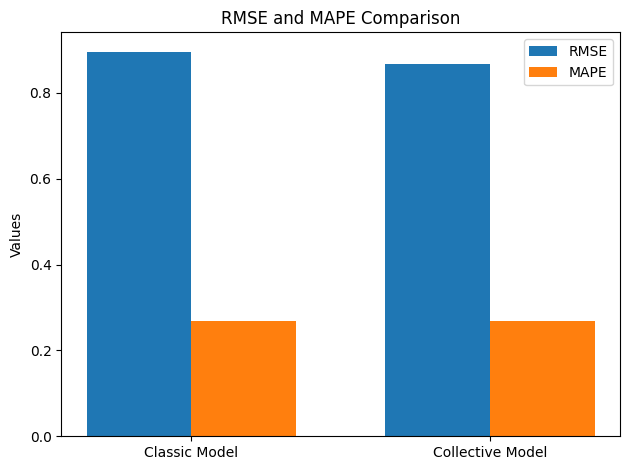

In [ ]:
# Performance evaluation: Accuracy of predictions with RMSE & MAPE

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Classic Model
y_classic = model_test_1.predict(ratings_test1["UserId"], ratings_test1["ItemId"])
rmse_classic = np.sqrt(mean_squared_error(ratings_test1["Rating"], y_classic))
rho_classic = np.corrcoef(ratings_test1["Rating"], y_classic)[0, 1]
mape_classic = mean_absolute_percentage_error(ratings_test1["Rating"], y_classic)

print("RMSE of the classic model: %.3f [rho: %.3f] [MAPE: %.3f]" % (rmse_classic, rho_classic, mape_classic))

# Collective Model
y_collective = model_test_2.predict(ratings_test1["UserId"], ratings_test1["ItemId"])
rmse_collective = np.sqrt(mean_squared_error(ratings_test1["Rating"], y_collective))
rho_collective = np.corrcoef(ratings_test1["Rating"], y_collective)[0, 1]
mape_collective = mean_absolute_percentage_error(ratings_test1["Rating"], y_collective)

print("RMSE of the collective model: %.3f [rho: %.3f] [MAPE: %.3f]" % (rmse_collective, rho_collective, mape_collective))

# Plotting the RMSE and MAPE values
models = ['Classic Model', 'Collective Model']
rmse_values = [rmse_classic, rmse_collective]
mape_values = [mape_classic, mape_collective]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE')
rects2 = ax.bar(x + width/2, mape_values, width, label='MAPE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE & MAPE Values')
ax.set_title('RMSE and MAPE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()

# Misc: Code for finding Sparse Matrix from Dense Form

In [ ]:
from scipy.sparse import csr_matrix

dense_matrix = np.array([[1, 0], [3, 7]])

sparse_matrix = csr_matrix(dense_matrix)

print(sparse_matrix)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	1
  (1, 0)	3
  (1, 1)	7
